# Investigating how Count Sketch scales with input sparsity

Key questions:
1. CountSketch (CWT) takes time $O(\text{nnz}(A))$ to apply to summarise a matrix, how does this scale on fixed design matrices as the density ($\rho$) is varied from $0 < \rho \le 1$?
2. How does the SRHT scale with sparsity/density? Ideally this should be near constant.

Hadamard implementation taken from https://bitbucket.org/vegarant/fastwht


In [4]:
#import sys            # calls the functions from above 
#sys.path.append("..") # directory instead of having them in the notebook.

import numpy as np
import scipy as sp
from scipy import sparse
import numba
from numba import jit
import itertools
from timeit import default_timer
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)

In [5]:
@jit(nopython=True)
def countSketch(input_matrix, sketch_size,seed=None):
    
    #np.random.seed(seed)
    n,d = input_matrix.shape
    sketch = np.zeros((sketch_size,d))
    nonzero_rows, nonzero_cols = np.nonzero(input_matrix)
    hashed_indices = np.random.choice(sketch_size, n, replace=True)
    
    # Generates entrie is 2*[0,1] - 1 == {-1,1}
    random_signs = 2*np.random.choice(a=2, size=n, replace=True) - 1
    
    for ii,jj in zip(nonzero_rows,nonzero_cols):
        bucket = hashed_indices[ii]
        sketch[bucket, jj] += random_signs[ii]*input_matrix[ii,jj]                                                        
    return sketch

In [6]:
from hadamard import fastwht

def shift_bit_length(x):
    '''Given int x find next largest power of 2.                                                              
    If x is a power of 2 then x is returned '''
    return 1<<(x-1).bit_length()


def srht_transform(input_matrix, sketch_size, seed=None):
        '''
        Generate a sketching matrix S to reduce the sample count (i.e. sketching                               
        on the LHS of data) via the Subsampled Hadamard Transform.                                                
                                                                                                              
        Given an input_matrix ``A`` of size ``(n, d)``, compute a matrix ``A'`` of                                
        size (sketch_size, d) which holds:                                                                        
        .. math:: ||Ax|| = (1 \pm \epsilon)||A'x||                                                                
        with high probability. [1]                                                                                
        The error is related to the number of rows of the sketch and it is bounded
        
        Parameters                                                                                                
        ----------                                                                                                
        input_matrix: ndarray                                                                                  
            Input matrix, of shape ``(n, d)``.                                                                    
        sketch_size: int                                                                                          
            Number of rows for the sketch.                                                                        
        seed : None or int or `numpy.random.RandomState` instance, optional                                       
            This parameter defines the ``RandomState`` object to use for drawing                                  
            random variates.                                                                                      
            If None (or ``np.random``), the global ``np.random`` state is used.                                   
            If integer, it is used to seed the local ``RandomState`` instance.                                    
            Default is None.                                                                                      
        
        Returns                                                                                                   
        -------                                                                                                   
        S_A : ndarray                                                                                          
            Sketch of the input matrix ``A``, of size ``(sketch_size, d)``.                                       
                                                                                                                                                   
                                                                                                              
        References 
        ---------
        [1] - https://arxiv.org/abs/1411.4357                                                                     
        [2] - https://bitbucket.org/vegarant/fastwht 
        '''
        np.random.seed(seed)
        # Mutliplying rows by random signs
        nrows = input_matrix.shape[0]
        diag = np.random.choice([1,-1], nrows)
        diag = diag[:,None]                                                            
        signed_mat = diag*input_matrix
        
        # Hadamard transform
        S = shift_bit_length(nrows)*fastwht(signed_mat)
        
        # subsampling
        sample = np.random.choice(nrows, sketch_size, replace=False)
        sample.sort()
        S = S[sample]
        S = (sketch_size)**(-0.5)*S
        return S


In [7]:
def test_time_sparsity(n_rows, n_cols, n_trials, sketch_size, densities):
    '''
    Function to automate the experiments measuring time 
    and varying sparsity for given input data.
    
    Inputs: n_rows, n_cols, n_trials, sketch_size all int
            densities - list of densities to try
            
    Output: Two dictionaries with key as density value tested and
    then the times associated with testing that experiment.
    One dict for CWT and one for SRHT.'''
    rho_str = [str(density) for density in densities]
    CWT_time = {}
    SRHT_time = {}


    for density in densities:
        A = sparse.random(n_rows,n_cols,density).toarray()
        print('Testing density', density)
        for trial in range(n_trials):
            print("Trial no. ", trial)
            CWT_summary_time = 0
            SRHT_summary_time = 0
    
            start = default_timer()
            CWT_A = countSketch(A,sketch_size,seed=None)
            CWT_summary_time += default_timer() - start
        
    
            start = default_timer()
            SRHT_A = srht_transform(A, sketch_size, seed=None)
            SRHT_summary_time = default_timer() - start
    
        CWT_time[str(density)] = CWT_summary_time/n_trials
        SRHT_time[str(density)] = SRHT_summary_time/n_trials
    
    return CWT_time, SRHT_time

In [5]:
# Quick test to make sure both working
# .toarray() convert to numpy array for the SRHT
A = sparse.random(5000,100, 0.25).toarray() 
x = np.random.randn(A.shape[1])
sketch_size = 500

# Sketching
CWT_A = countSketch(A,sketch_size,seed=10)
SRHT_A = srht_transform(A, sketch_size,seed=10)

# norm preservation
true_mat_vec_norm = np.linalg.norm(A@x)**2
true_mat_mat_norm = np.linalg.norm(A.T@A, ord='fro')**2

CWT_mat_vec_norm = np.linalg.norm(CWT_A@x)**2
CWT_mat_mat_norm = np.linalg.norm(CWT_A.T@CWT_A, ord='fro')**2

CWT_mat_vec_rel_error = CWT_mat_vec_norm / true_mat_vec_norm
CWT_mat_mat_rel_error = CWT_mat_mat_norm / true_mat_mat_norm

SRHT_mat_vec_norm = np.linalg.norm(SRHT_A@x)**2
SRHT_mat_mat_norm = np.linalg.norm(SRHT_A.T@SRHT_A, ord='fro')**2

SRHT_mat_vec_rel_error = SRHT_mat_vec_norm / true_mat_vec_norm
SRHT_mat_mat_rel_error = SRHT_mat_mat_norm / CWT_mat_mat_norm

print("CWT")
print("Inner product relative error: {}".format(CWT_mat_vec_rel_error))
print("Hessian matrix relative error: {}".format(CWT_mat_mat_rel_error))
print("--"*25)
print("SRHT")
print("Inner product relative error: {}".format(SRHT_mat_vec_rel_error))
print("Hessian matrix relative error: {}".format(SRHT_mat_mat_rel_error))

CWT
Inner product relative error: 0.9517560102811403
Hessian matrix relative error: 1.2905708481387743
--------------------------------------------------
SRHT
Inner product relative error: 0.9618759362015921
Hessian matrix relative error: 0.9179617263090126


Now we will experiment by exploring how varying the density of the data affects the time to apply a sketch.  The density is measured as the fraction of nonzeros in the matrix.


Setup:
* Design matrix $A$ of size $(n,d)$ to be determined at the start of the experiment.
* Fix a sketch size.  Currently used $10d$ but can vary this in the call to `test_time_sparsity`
* Fix an input density $0 < \rho \le 1$
* Take `num_trials` number of repeats and measure the mean time taken to perform the summarisation. 

In [6]:
# Control parameters
n,d = 100000, 50
data_densities = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
sketch_size = 500

num_trials = 5


# Measurable times
rho_str = [str(density) for density in data_densities]
CWT_time = {}
SRHT_time = {}


for density in data_densities:
    A = sparse.random(n,d,density).toarray()
    print('Testing density', density)
    for trial in range(num_trials):
        print("Trial no. ", trial)
        CWT_summary_time = 0
        SRHT_summary_time = 0
    
        start = default_timer()
        CWT_A = countSketch(A,sketch_size,seed=None)
        CWT_summary_time += default_timer() - start
        
    
        start = default_timer()
        SRHT_A = srht_transform(A, sketch_size, seed=None)
        SRHT_summary_time = default_timer() - start
    
    CWT_time[str(density)] = CWT_summary_time/num_trials
    SRHT_time[str(density)] = SRHT_summary_time/num_trials

Testing density 0.01
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.05
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.1
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.25
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.5
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.75
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 1.0
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4


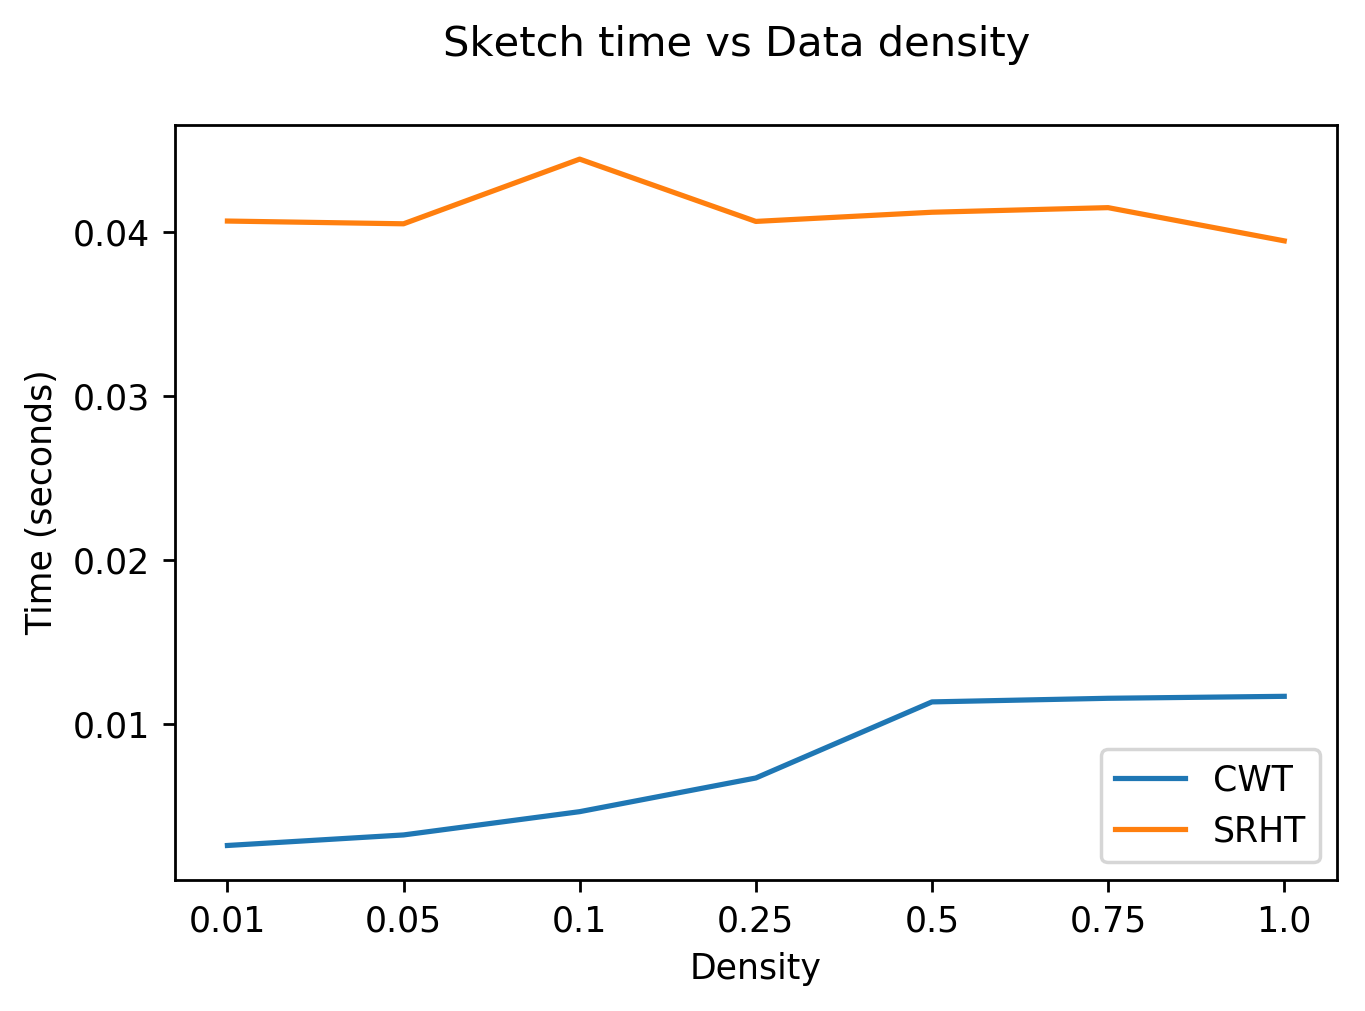

In [7]:
fig, ax = plt.subplots(dpi=250, facecolor='w', edgecolor='k')
fig.suptitle("Sketch time vs Data density")
ax.plot(*zip(*sorted(CWT_time.items())), label='CWT')
ax.plot(*zip(*sorted(SRHT_time.items())), label='SRHT')
ax.set_xlabel("Density")
ax.set_ylabel("Time (seconds)")
ax.legend()

#### Testing $n=100000$.

There is a memory error when we increase the number of rows in the matrix and the number of columns is sufficiently large i.e. $1000+$ so for illustration just consider a matrix of $100,000$ rows as this shows the scaling as $d$ increases.

In [8]:
param_grid = {
    'num trials' : 5,
    'rows' : [100000],
    'columns' : [10, 100, 1000, 2000],
    'density' : [0.01, 0.1, 0.25, 0.5, 1.0]
}

results = {}

for n_rows, n_cols in itertools.product(param_grid['rows'], param_grid['columns']):
    n_trials = param_grid['num trials']
    print('Testing design matrix ({},{})'.format(n_rows, n_cols))
    sketch_size = 10*n_cols
    C_T, S_T =  test_time_sparsity(n_rows, n_cols, n_trials,sketch_size,param_grid['density'])
    results[(n_rows, n_cols, "CWT")] = C_T
    results[(n_rows, n_cols, "SRHT")] = S_T
    

Testing design matrix (100000,10)
Testing density 0.01
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.1
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.25
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.5
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 1.0
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing design matrix (100000,100)
Testing density 0.01
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.1
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.25
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 0.5
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing density 1.0
Trial no.  0
Trial no.  1
Trial no.  2
Trial no.  3
Trial no.  4
Testing design matrix (100000,1000)
Testing density 0.01
Trial no.  0
Trial n

In [11]:
#np.save('sparsity_time.npy', results) 
#read_dict =  np.load('sparsity_time.npy').item()
#read_dict

(100000, 1000, 'CWT')
(100000, 2000, 'SRHT')
(100000, 10, 'CWT')
(100000, 10, 'SRHT')
(100000, 2000, 'CWT')
(100000, 1000, 'SRHT')
(100000, 100, 'CWT')
(100000, 100, 'SRHT')


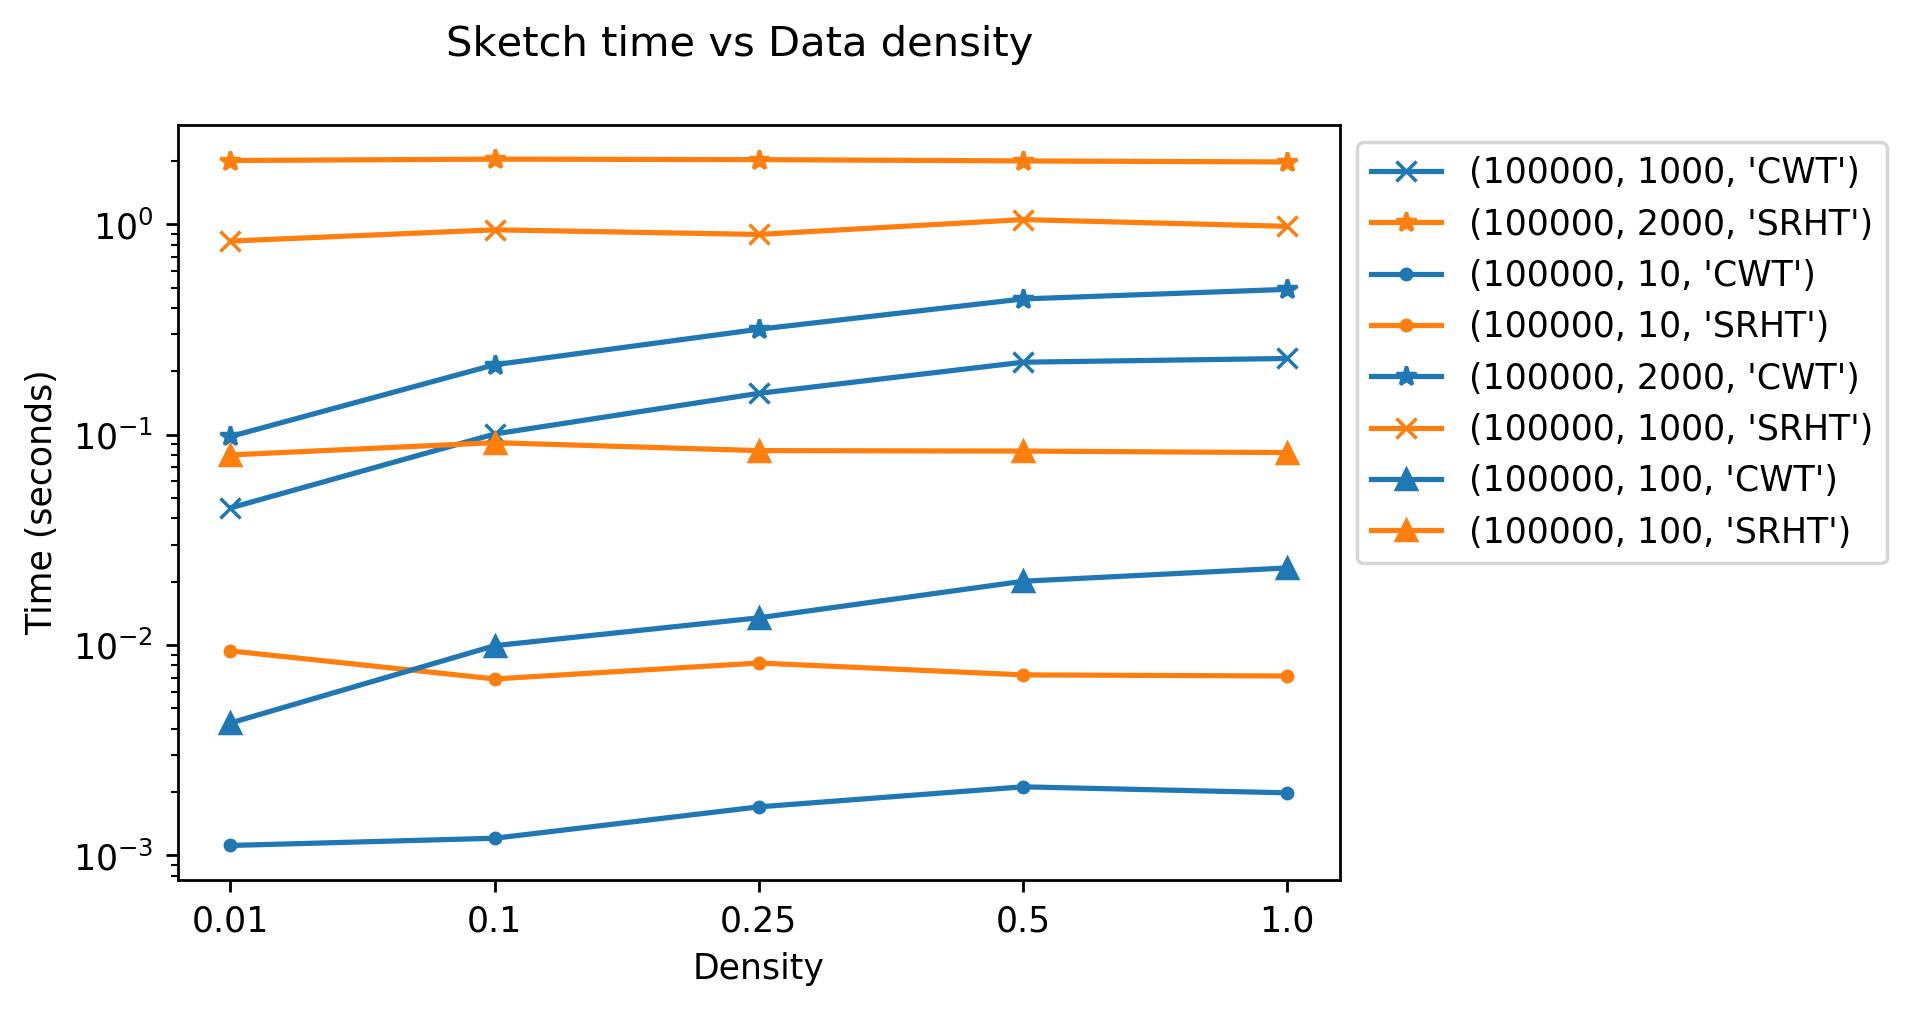

In [16]:
markers = {10: '.', 100 : '^', 250 : 's',
           500 : 'D', 1000: 'x', 2000: '*'}
fig, ax = plt.subplots(dpi=250, facecolor='w', edgecolor='k')
fig.suptitle("Sketch time vs Data density")

for parameters in results.keys():
    print(parameters)
    n = int(parameters[0])
    d = int(parameters[1])
    method = parameters[2]
    
    
    if method == 'CWT':
        col = 'C0'
    else:
        col = 'C1'
        
    
    ax.plot(*zip(*sorted(results[parameters].items())),
            label=(parameters), color=col, marker=markers[d])
    
handles,labels = ax.get_legend_handles_labels()
#labels = [labels[0], labels[2], labels[4], labels[6],
#          labels[1], labels[3], labels[5], labels[7]]
#handles = [handles[0], handles[2], handles[4], handles[6],
#           handles[1], handles[3], handles[5], handles[7]]
ax.set_yscale('log')
ax.set_xlabel("Density")
ax.set_ylabel("Time (seconds)")
#ax.grid()
ax.legend(handles, labels, bbox_to_anchor=(1.0, 1.0))

In [35]:
#labels = [labels[0], labels[2], labels[1], labels[3]]
#handles = [handles[0], handles[2], handles[1], handles[3]]
labels = list(labels)
new_labels = [labels[2], labels[6], labels[0], labels[4],
               labels[3], labels[7], labels[5], labels[1]]
new_handles = [handles[2], handles[6], handles[0], handles[4],
               handles[3], handles[7], handles[5], handles[1]]
print(new_labels)


["(10, 'CWT')", "(100, 'CWT')", "(1000, 'CWT')", "(2000, 'CWT')", "(10, 'SRHT')", "(100, 'SRHT')", "(1000, 'SRHT')", "(2000, 'SRHT')"]


(100000, 1000, 'CWT')
(100000, 2000, 'SRHT')
(100000, 10, 'CWT')
(100000, 10, 'SRHT')
(100000, 2000, 'CWT')
(100000, 1000, 'SRHT')
(100000, 100, 'CWT')
(100000, 100, 'SRHT')


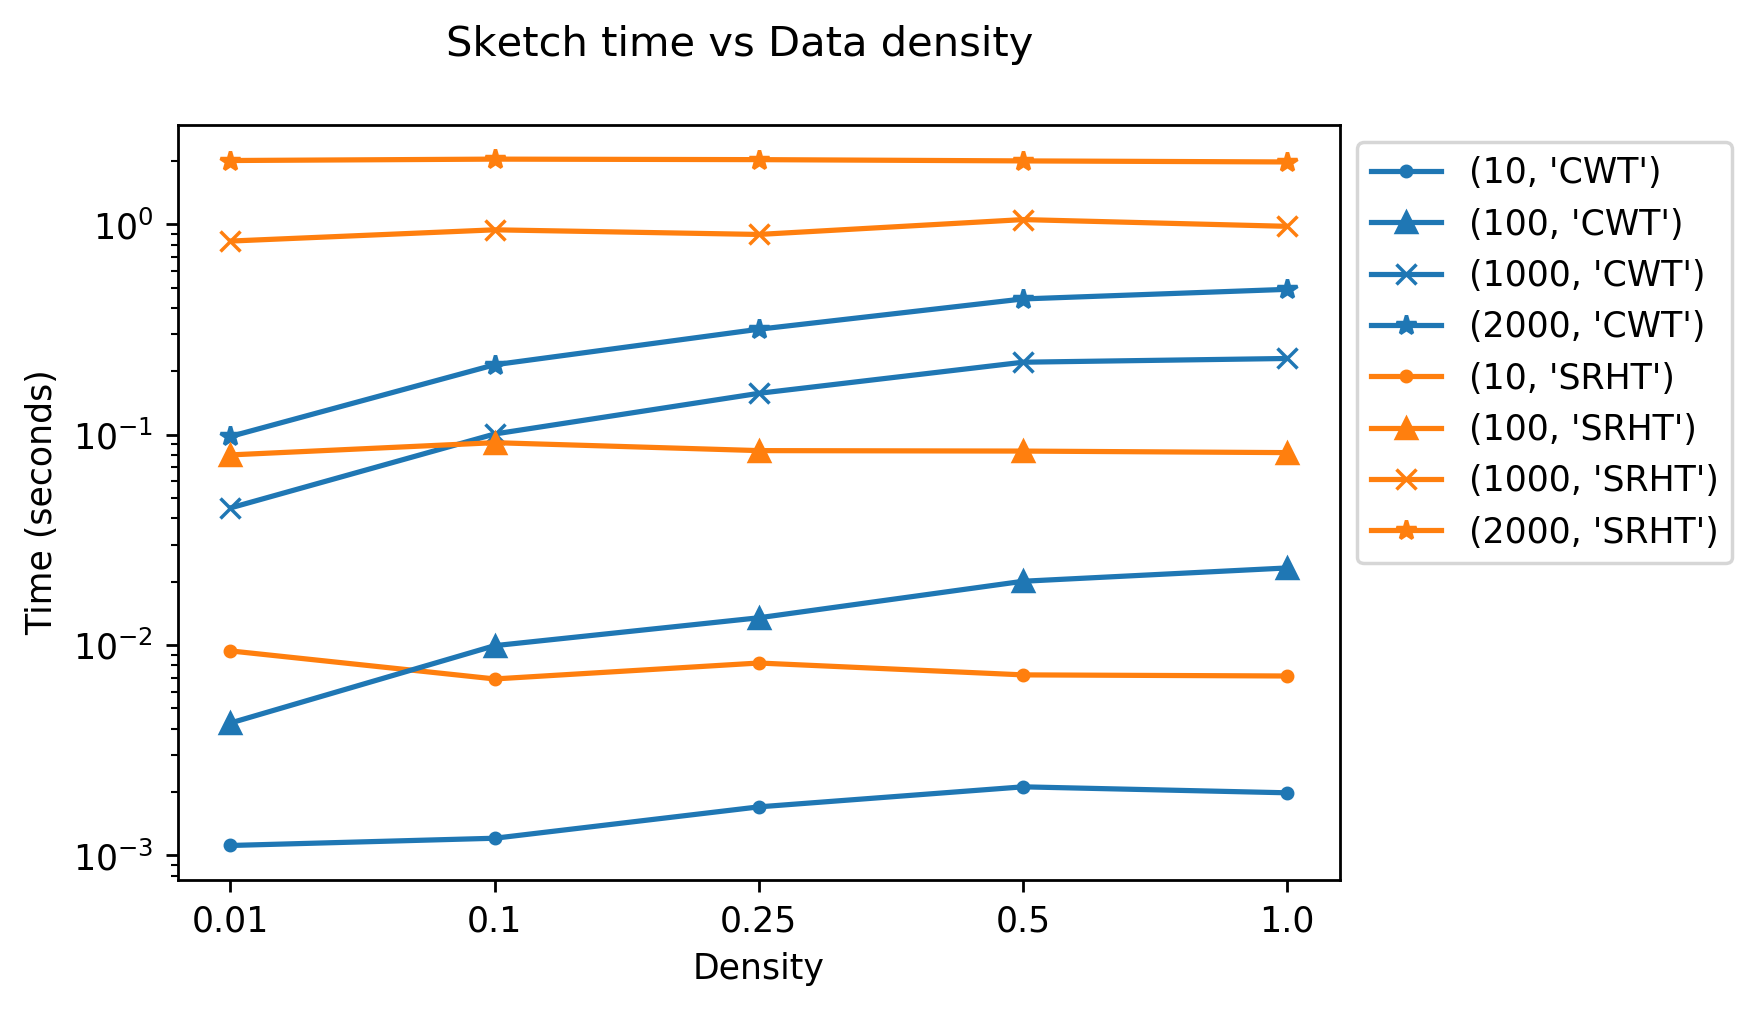

In [36]:
# Relies on the above to sort the legend.
# savefig cuts off the title from the saved plot.

markers = {10: '.', 100 : '^', 250 : 's',
           500 : 'D', 1000: 'x', 2000: '*'}
fig, ax = plt.subplots(dpi=250, facecolor='w', edgecolor='k')
fig.suptitle("Sketch time vs Data density")

for parameters in results.keys():
    print(parameters)
    n = int(parameters[0])
    d = int(parameters[1])
    method = parameters[2]
    
    
    if method == 'CWT':
        col = 'C0'
    else:
        col = 'C1'
        
    
    ax.plot(*zip(*sorted(results[parameters].items())),
            label=(d,method), color=col, marker=markers[d])
    
handles,labels = ax.get_legend_handles_labels()
#labels = [labels[0], labels[2], labels[4], labels[6],
#          labels[1], labels[3], labels[5], labels[7]]
#handles = [handles[0], handles[2], handles[4], handles[6],
#           handles[1], handles[3], handles[5], handles[7]]
ax.set_yscale('log')
ax.set_xlabel("Density")
ax.set_ylabel("Time (seconds)")
#ax.grid()
lgd = ax.legend(new_handles, new_labels, bbox_to_anchor=(1.0, 1.0))
fig.savefig('sparsity-time-1e5.pdf', bbox_extra_artists=(lgd,),
            bbox_inches='tight',orientation='landscape')

### Streaming the Hessian Sketch
The streaming approach to Hessian Sketch is a two-phase algorithm which first summarises the data, and secondly performs the descent.  To implement this properly, we need to know how to compute a summary of the data in a streaming fashion but also how to do this in parallel to create a number of summaries used in the iterations.

In [84]:
import multiprocessing
from multiprocessing import Pool
from timeit import default_timer

In [87]:
CPU_COUNT = multiprocessing.cpu_count()
print(CPU_COUNT)

4


In [95]:
A = np.random.randn(100000,100)
sketch_size = 500
p = Pool(CPU_COUNT)
def parallel_countSketch(A):
    return countSketch(A, sketch_size)

In [91]:
%timeit countSketch(A, 500)

125 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
sketches = list(map(lambda A: countSketch(A, 10), [A for i in range(4)]))
#sketches

summaries = p.map(parallel_countSketch, [A for i in range(20)])

Process ForkPoolWorker-94:
Process ForkPoolWorker-85:
Process ForkPoolWorker-91:
Process ForkPoolWorker-90:
Process ForkPoolWorker-79:
Process ForkPoolWorker-82:
Process ForkPoolWorker-98:
Process ForkPoolWorker-83:
Process ForkPoolWorker-84:
Process ForkPoolWorker-80:
Process ForkPoolWorker-87:
Process ForkPoolWorker-93:
Process ForkPoolWorker-97:
Process ForkPoolWorker-81:
Process ForkPoolWorker-95:
Traceback (most recent call last):
Process ForkPoolWorker-86:
Process ForkPoolWorker-92:
Process ForkPoolWorker-96:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-89:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last

  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/anaconda/envs/py35/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/anaconda/envs/py35/lib/pytho

In [99]:
#start = default_timer()
%timeit p.map(parallel_countSketch, [A for i in range(8)])
#time = default_timer() - start
#print(time)

2.03 s ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
def serial_countSketch(A,s):
    sketches = []
    for i in range(8):
        sketch = countSketch(A,s)
        sketches.append(sketch)
    return sketches

In [101]:
%timeit serial_countSketch(A,sketch_size)

968 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def parallel_countSketch(input_matrix, sketch_size, num_summaries):
    '''
    Function to compute a number of countSketch summaries of the 
    data in parallel.
    
    Input:
    input_matrix - ndarray data to be streamed
    sketch_size - int, the size of the summary to be retained
    num_summaries - int, the number of summaries to compute
    
    Output:
    '''